# Experimentation and Results

## Objective of the project 

This study seeks to conduct a thorough comparative analysis of these three models, focusing
on their performance with regards to accuracy, computational complexity, scalability, and their
effectiveness in handling data sparsity and dynamically changing environments. By evaluat-
ing these aspects, the research aims to illuminate the operational strengths and weaknesses
of each model, providing clear insights that could guide the development and deployment of
future recommender systems. Through this comparative framework, we aspire to answer which
model, under what conditions, provides the most reliable and robust recommendations, thereby
significantly contributing to the optimization of digital services.

In [13]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter, defaultdict
from surprise import Dataset, Reader, KNNBasic, SVD, CoClustering, accuracy
#from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from surprise.accuracy import rmse, mae

In [5]:
links_df = pd.read_csv('MovieLens_100k/links.csv')
movies_df = pd.read_csv('MovieLens_100k/movies.csv')
ratings_df = pd.read_csv('MovieLens_100k/ratings.csv')
tags_df = pd.read_csv('MovieLens_100k/tags.csv')

datasets = {
    "Links": links_df,
    "Movies": movies_df,
    "Ratings": ratings_df,
    "Tags": tags_df
}

datasets_info = {name: df.head() for name, df in datasets.items()}
datasets_info

{'Links':    movieId  imdbId   tmdbId
 0        1  114709    862.0
 1        2  113497   8844.0
 2        3  113228  15602.0
 3        4  114885  31357.0
 4        5  113041  11862.0,
 'Movies':    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
 'Ratings':    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  9

## Dataset structure

In [6]:
# Check for missing values in each dataset
missing_values = {name: df.isnull().sum() for name, df in datasets.items()}

# Print the information about missing values
for name, missing in missing_values.items():
    print(f"Missing values in {name} dataset:\n{missing}\n")

Missing values in Links dataset:
movieId    0
imdbId     0
tmdbId     8
dtype: int64

Missing values in Movies dataset:
movieId    0
title      0
genres     0
dtype: int64

Missing values in Ratings dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in Tags dataset:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64



In [7]:
# Print the shape of each DataFrame
for name, df in datasets.items():
    print(f"The shape of the {name} DataFrame is: {df.shape}")

The shape of the Links DataFrame is: (9742, 3)
The shape of the Movies DataFrame is: (9742, 3)
The shape of the Ratings DataFrame is: (100836, 4)
The shape of the Tags DataFrame is: (3683, 4)


In [8]:
distribution_of_ratings = ratings_df.groupby('rating').size().reset_index(name='count')
distribution_of_ratings

,rating,count
0,0.5,1370
1,1.0,2811
2,1.5,1791
3,2.0,7551
4,2.5,5550
5,3.0,20047
6,3.5,13136
7,4.0,26818
8,4.5,8551
9,5.0,13211


# Collaborative Filtering Algorithms

### For the collaborative filtering, we have implemented 3 algorithms liisted below: 

### a. KNNBasic (K-Nearest Neighbors)
The KNNBasic algorithm leverages the k-nearest neighbors technique to predict user ratings
based on the weighted average of ratings from similar users or items. For KNN, we have chosen 3 different similarity measures to test: Pearson, Pearson baseline and Mean squared difference. Refer to the technical report for more detail. 

### b. SVD (Singular Value Decomposition)
SVD: SVD is a matrix factorization technique that decomposes the user-item rating matrix into
latent factors, enabling the prediction of ratings through these latent factors.

### c. CoClustering
CoClustering: CoClustering simultaneously clusters users and items to uncover hidden re-
lationships in the data, facilitating more accurate rating predictions.

### Useful functions 

In [10]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions."""
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Map the predictions to only the top N items
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def get_top_n_recommendations(user_id, n=10):
    # Get a list of all movies in the dataset
    all_movies = movies_df['movieId'].unique()
    
    # Get movies that the user has already rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    
    # Predict ratings for all movies the user hasn't rated yet
    predictions = []
    for movie_id in set(all_movies) - set(rated_movies):
        pred = model.predict(uid=user_id, iid=movie_id)
        predictions.append((movie_id, pred.est))
    
    # Sort the predictions by estimated rating in descending order and select the top N
    top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    
    # Map the movie IDs back to titles
    top_n_movies = [(movies_df[movies_df['movieId'] == mid]['title'].values[0], est) for mid, est in top_n]
    
    return top_n_movies

def precision_recall_at_k(predictions, k=10, threshold=0.7):  
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))
        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

def compute_mse(predictions):
    """Compute Mean Squared Error (MSE)."""
    mse = np.mean([(true_r - est) ** 2 for (_, _, true_r, est, _) in predictions])
    return mse

def compute_rmse(predictions):
    """Compute Root Mean Squared Error (RMSE)."""
    mse = compute_mse(predictions)
    rmse = np.sqrt(mse)
    return rmse

def compute_mae(predictions):
    """Compute Mean Absolute Error (MAE)."""
    mae = np.mean([abs(true_r - est) for (_, _, true_r, est, _) in predictions])
    return mae

def get_sparse_data(ratings, frac=0.1):
    sparse_ratings_df = ratings.sample(frac=frac, random_state=42)  
    return sparse_ratings_df

def get_new_user_data(ratings, frac=0.1):
    new_user_ratings_df = ratings[ratings['userId'].isin(ratings['userId'].sample(frac=frac, random_state=42))]
    return new_user_ratings_df

### In this part, we use the Surprise library, renowned for its robust implementation of various collaborative filtering algorithms, to evaluate different recommendation system models. Specifically, we implement KNNBasic, SVD, and CoClustering algorithms, chosen for their widespread recognition and effectiveness in collaborative filtering tasks. 

In [41]:
#Function to evaluate a model with a given algorithm and similarity measure
def evaluate_algorithm(algo_name, similarity_measure, train_set, test_set, user_based=True):
    if algo_name == 'KNNBasic':
        sim_options = {
            'name': similarity_measure,
            'user_based': user_based
        }
        model = KNNBasic(sim_options=sim_options)
    elif algo_name == 'SVD':
        model = SVD()
    elif algo_name == 'CoClustering':
        model = CoClustering()

    # Measure start time
    start_time = time.time()
    
    # Train the model
    model.fit(train_set)
    
    # Make predictions on the test set
    predictions = model.test(test_set)

    # Measure end time
    end_time = time.time()
    # Calculate running time
    running_time = end_time - start_time
    
    # Evaluate accuracy
    mse_score = accuracy.mse(predictions, verbose=False)
    rmse_score = accuracy.rmse(predictions, verbose=False)
    mae_score = accuracy.mae(predictions, verbose=False)

    # mse_score= compute_mse(predictions)
    # rmse_score= compute_rmse(predictions)
    # mae_score= compute_mae(predictions)
    
    # Compute precision and recall
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=0.7)
    precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
    recall_avg = sum(rec for rec in recalls.values()) / len(recalls)
    
    return algo_name, similarity_measure, user_based, mse_score, rmse_score, mae_score, precision_avg, recall_avg, running_time

# Function to evaluate all scenarios
def evaluate_all_scenarios(train_set, test_set, scenario_name):
    results_combined = []
    for algo_name, similarity_measure in algorithms:
        for user_based in [True, False]:
            algo_name, similarity_measure, user_based, mse_score, rmse_score, mae_score, precision_avg, recall_avg, running_time = evaluate_algorithm(algo_name, similarity_measure, train_set, test_set, user_based)
            results_combined.append({
                'Scenario': scenario_name,
                'Algorithm': algo_name,
                'Similarity Measure': similarity_measure if similarity_measure else 'N/A',
                'User-Based': user_based,
                'MSE': mse_score,
                'RMSE': rmse_score,
                'MAE': mae_score,
                'Precision@10': precision_avg,
                'Recall@10': recall_avg,
                'Running Time (s)': running_time
            })
    return results_combined


reader = Reader(rating_scale=(ratings_df['rating'].min(), ratings_df['rating'].max()))

# Step 1: Split the data into training and test sets (80% training, 20% testing)
train_df, test_df = train_test_split(ratings_df, test_size=0.20, random_state=42)

# Convert the training set into a Surprise dataset
train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
train_set = train_data.build_full_trainset()

# Convert the test set into a Surprise dataset for later use
test_data = Dataset.load_from_df(test_df[['userId', 'movieId', 'rating']], reader)
test_set = test_data.build_full_trainset().build_testset()

# Step 2: Create the sparse training set from the 80% training data
sparse_train_df = get_sparse_data(train_df, frac=0.1)
sparse_data = Dataset.load_from_df(sparse_train_df[['userId', 'movieId', 'rating']], reader)
sparse_train_set = sparse_data.build_full_trainset()

# Step 3: Create the new user training set from the 80% training data
new_user_train_df = get_new_user_data(train_df, frac=0.1)
new_user_data = Dataset.load_from_df(new_user_train_df[['userId', 'movieId', 'rating']], reader)
new_user_train_set = new_user_data.build_full_trainset()


# Output to check
train_set.n_ratings, len(test_set)

# List of algorithms and their similarity measures to evaluate
algorithms = [
    ('KNNBasic', 'pearson'),
    ('KNNBasic', 'pearson_baseline'),
    ('KNNBasic', 'msd'),
    ('SVD', None),  # SVD does not use similarity measures
    ('CoClustering', None)  # CoClustering does not use similarity measures
]

In [19]:
results_CF= pd.DataFrame(results_normal + results_sparse + results_new_user)
results_CF

,Scenario,Algorithm,Similarity Measure,User-Based,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,Normal,KNNBasic,pearson,True,0.217433,0.167403,0.681419,0.482391,1.577275
1,Normal,KNNBasic,pearson,False,0.214941,0.166982,0.517631,0.389731,14.983212
2,Normal,KNNBasic,pearson_baseline,True,0.217501,0.167079,0.676271,0.487729,1.601246
3,Normal,KNNBasic,pearson_baseline,False,0.204038,0.154259,0.609774,0.461591,12.312512
4,Normal,KNNBasic,msd,True,0.213605,0.163704,0.672722,0.488166,1.281166
5,Normal,KNNBasic,msd,False,0.202160,0.155620,0.522313,0.417250,10.443120
6,Normal,SVD,N/A,True,0.199440,0.153197,0.636856,0.450793,1.219783
7,Normal,SVD,N/A,False,0.199464,0.153466,0.636138,0.449077,1.084938
8,Normal,CoClustering,N/A,True,0.558738,0.512389,0.111245,0.032385,2.333833
9,Normal,CoClustering,N/A,False,0.561689,0.513963,0.144278,0.042020,2.316910


In [33]:
# Evaluate normal scenario
results_normal = evaluate_all_scenarios(train_set, test_set, "Normal")

# Evaluate sparse data scenario
results_sparse = evaluate_all_scenarios(sparse_train_set, test_set, "Sparse")

# Evaluate new user data scenario
results_new_user = evaluate_all_scenarios(new_user_train_set, test_set, "New User")

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Compu

In [34]:
results_CF= pd.DataFrame(results_normal + results_sparse + results_new_user)
results_CF

,Scenario,Algorithm,Similarity Measure,User-Based,MSE,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,Normal,KNNBasic,pearson,True,0.047447,0.217822,0.168082,0.689299,0.492621,1.529102
1,Normal,KNNBasic,pearson,False,0.047217,0.217295,0.168717,0.517611,0.398195,18.764348
2,Normal,KNNBasic,pearson_baseline,True,0.047433,0.217790,0.167656,0.688259,0.496251,1.583247
3,Normal,KNNBasic,pearson_baseline,False,0.041960,0.204842,0.155043,0.625488,0.474030,11.467633
4,Normal,KNNBasic,msd,True,0.046086,0.214677,0.164979,0.679926,0.499211,1.255274
5,Normal,KNNBasic,msd,False,0.041458,0.203612,0.156361,0.531894,0.413416,9.768819
6,Normal,SVD,N/A,True,0.041005,0.202497,0.155352,0.647672,0.459548,1.190404
7,Normal,SVD,N/A,False,0.041094,0.202715,0.155254,0.626419,0.453290,1.149808
8,Normal,CoClustering,N/A,True,0.313754,0.560137,0.511696,0.175363,0.044782,2.664798
9,Normal,CoClustering,N/A,False,0.310585,0.557301,0.510051,0.131653,0.036242,2.510326


### Observation

User-based algorithms generally outperformed item-based algorithms across the different sce-
narios tested. Specifically, KNNBasic with Pearson similarity in a user-based setting demon-
strated competitive performance, particularly excelling in the normal and new user scenarios.
It achieved notable metrics, including high Precision@10 and Recall@10, highlighting its ef-
fectiveness in these contexts. SVD consistently delivered strong results across all scenarios,
achieving the lowest RMSE and MAE values, coupled with high Precision@10 and Recall@10.
This consistent performance, combined with relatively short running times, underscores SVD’s
robustness and reliability as a recommendation algorithm for the dataset we have worked on.

# Graph-based Algorithms

### For the graph-based models, we have implemented 3 algorithms as well: LightGCN, Graph Attention Network, GraphSAGE
Graph Construction: In the graph construction phase, nodes are created to represent both users
and movies, while edges represent the interactions between these users and movies based on
their ratings. To facilitate this, numpy is utilized for constructing the adjacency matrix, which
captures the user-movie interaction graph in a structured form. This adjacency matrix serves
as the foundation for various graph-based algorithms, allowing us to represent the relationships
between users and movies effectively. Additionally, TensorFlow is employed to handle the graph
representation and computation, leveraging its powerful capabilities for efficient processing and
model training in subsequent stages. 

### In this first part of the code, we have implemented all the useful functions and code that all the 3 algorithms shared in commun to avoid code redundancy. 

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

# Load the dataset
ratings_df = pd.read_csv('MovieLens_100k/ratings.csv')
movies_df = pd.read_csv('MovieLens_100k/movies.csv')

# Data Preprocessing
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings_df['user'] = user_encoder.fit_transform(ratings_df['userId'])
ratings_df['item'] = item_encoder.fit_transform(ratings_df['movieId'])

num_users = ratings_df['user'].nunique()
num_items = ratings_df['item'].nunique()


def evaluate_model(model, train_data, test_data, adj_matrix=None):
    # Prepare the training data
    user_indices = train_data['userId'].values
    item_indices = train_data['movieId'].values
    labels = train_data['rating'].values

    dataset = tf.data.Dataset.from_tensor_slices((user_indices, item_indices, labels))
    dataset = dataset.shuffle(buffer_size=len(train_data)).batch(256)

    # Training loop
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.MeanSquaredError()  

    @tf.function
    def train_step(user_indices, item_indices, labels):
        with tf.GradientTape() as tape:
            if adj_matrix is not None:
                scores = model(user_indices, item_indices, adj_matrix)
            else:
                scores = model(user_indices, item_indices)
            loss = loss_fn(labels, scores)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    num_epochs = 10
    start_time = time.time()

    for epoch in range(num_epochs):
        for batch in dataset:
            user_indices_batch, item_indices_batch, labels_batch = batch
            loss = train_step(user_indices_batch, item_indices_batch, labels_batch)
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

    training_time = time.time() - start_time

    # Evaluating the model
    predictions = []

    test_user_indices = test_data['user'].values
    test_item_indices = test_data['item'].values
    test_labels = test_data['rating'].values

    for (user_index, item_index, label) in zip(test_user_indices, test_item_indices, test_labels):
        user_index_tensor = tf.constant([user_index])
        item_index_tensor = tf.constant([item_index])
        if adj_matrix is not None:
            score = model(user_index_tensor, item_index_tensor, adj_matrix).numpy()[0]
        else:
            score = model(user_index_tensor, item_index_tensor).numpy()[0]
        predictions.append((user_index, item_index, label, score, 0))

    return predictions, training_time

def compute_metrics(predictions):
    def get_top_n(predictions, n=10):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    def precision_recall_at_k(predictions, k=10, threshold=0.7): 
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))
        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

    def compute_mse(predictions):
        """Compute Mean Squared Error (MSE)."""
        mse = np.mean([(true_r - est) ** 2 for (_, _, true_r, est, _) in predictions])
        return mse

    
    def compute_rmse(predictions):
        """Compute Root Mean Squared Error (RMSE)."""
        mse = compute_mse(predictions)
        rmse = np.sqrt(mse)
        return rmse

    def compute_mae(predictions):
        mae = np.mean([abs(true_r - est) for (_, _, true_r, est, _) in predictions])
        return mae

    mse = compute_mse(predictions)
    rmse = compute_rmse(predictions)
    mae = compute_mae(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=10)

    precision_at_10 = np.mean(list(precisions.values()))
    recall_at_10 = np.mean(list(recalls.values()))

    return mse,rmse, mae, precision_at_10, recall_at_10

# Function to run evaluation for each model and scenario
def run_evaluation(model, model_name, train_data, test_data, adj_matrix=None):
    predictions, training_time = evaluate_model(model, train_data, test_data, adj_matrix)
    mse,rmse, mae, precision_at_10, recall_at_10 = compute_metrics(predictions)
    results = pd.DataFrame({
        "Scenario": [scenario],
        "Algorithm": [model_name],
        "MSE": [mse],
        "RMSE": [rmse],
        "MAE": [mae],
        "Precision@10": [precision_at_10],
        "Recall@10": [recall_at_10],
        "Running Time (s)": [training_time]
    })
    return results

## LightGCN Algorithms

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the dataset
ratings_df = pd.read_csv('MovieLens_100k/ratings.csv')
movies_df = pd.read_csv('MovieLens_100k/movies.csv')

# Data Preprocessing
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings_df['user'] = user_encoder.fit_transform(ratings_df['userId'])
ratings_df['item'] = item_encoder.fit_transform(ratings_df['movieId'])

num_users = ratings_df['user'].nunique()
num_items = ratings_df['item'].nunique()

def evaluate_model(model, train_data, test_data, adj_matrix=None):
    # Prepare the training data
    user_indices = train_data['user'].values
    item_indices = train_data['item'].values
    labels = train_data['rating'].values

    dataset = tf.data.Dataset.from_tensor_slices((user_indices, item_indices, labels))
    dataset = dataset.shuffle(buffer_size=len(train_data)).batch(256)

    # Training loop
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.MeanSquaredError()  

    @tf.function
    def train_step(user_indices, item_indices, labels):
        with tf.GradientTape() as tape:
            scores = model((user_indices, item_indices))
            loss = loss_fn(labels, scores)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    num_epochs = 10
    start_time = time.time()

    for epoch in range(num_epochs):
        for batch in dataset:
            user_indices_batch, item_indices_batch, labels_batch = batch
            loss = train_step(user_indices_batch, item_indices_batch, labels_batch)
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

    training_time = time.time() - start_time

    # Evaluating the model
    predictions = []

    test_user_indices = test_data['user'].values
    test_item_indices = test_data['item'].values
    test_labels = test_data['rating'].values

    for (user_index, item_index, label) in zip(test_user_indices, test_item_indices, test_labels):
        user_index_tensor = tf.constant([user_index])
        item_index_tensor = tf.constant([item_index])
        score = model((user_index_tensor, item_index_tensor)).numpy()[0]
        predictions.append((user_index, item_index, label, score, 0))

    return predictions, training_time

def compute_metrics(predictions):
    def get_top_n(predictions, n=10):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    def precision_recall_at_k(predictions, k=10, threshold=3.5): 
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))
        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

    def compute_mse(predictions):
        """Compute Mean Squared Error (MSE)."""
        mse = np.mean([(true_r - est) ** 2 for (_, _, true_r, est, _) in predictions])
        return mse

    def compute_rmse(predictions):
        """Compute Root Mean Squared Error (RMSE)."""
        mse = compute_mse(predictions)
        rmse = np.sqrt(mse)
        return rmse

    def compute_mae(predictions):
        mae = np.mean([abs(true_r - est) for (_, _, true_r, est, _) in predictions])
        return mae

    mse = compute_mse(predictions)
    rmse = compute_rmse(predictions)
    mae = compute_mae(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=10)

    precision_at_10 = np.mean(list(precisions.values()))
    recall_at_10 = np.mean(list(recalls.values()))

    return mse, rmse, mae, precision_at_10, recall_at_10

# Function to run evaluation for each model and scenario
def run_evaluation(model, model_name, train_data, test_data, adj_matrix=None):
    predictions, training_time = evaluate_model(model, train_data, test_data, adj_matrix)
    mse, rmse, mae, precision_at_10, recall_at_10 = compute_metrics(predictions)
    results = pd.DataFrame({
        "Scenario": [scenario],
        "Algorithm": [model_name],
        "MSE": [mse],
        "RMSE": [rmse],
        "MAE": [mae],
        "Precision@10": [precision_at_10],
        "Recall@10": [recall_at_10],
        "Running Time (s)": [training_time]
    })
    return results

# Evaluate LightGCN
class LightGCN(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim, **kwargs):
        super(LightGCN, self).__init__(**kwargs)
        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_dim)
        self.item_embedding = tf.keras.layers.Embedding(num_items, embedding_dim)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def call(self, inputs):
        user_indices, item_indices = inputs
        user_embeddings = self.user_embedding(user_indices)
        item_embeddings = self.item_embedding(item_indices)
        scores = tf.reduce_sum(user_embeddings * item_embeddings, axis=1)
        return scores

    def get_config(self):
        config = super(LightGCN, self).get_config()
        config.update({
            'num_users': self.num_users,
            'num_items': self.num_items,
            'embedding_dim': self.embedding_dim,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

embedding_dim = 64
lightgcn_model = LightGCN(num_users, num_items, embedding_dim)

# Step 1: Split the data into training and test sets (80% training, 20% testing)
train_df, test_df = train_test_split(ratings_df, test_size=0.20, random_state=42)

# Callbacks for early stopping and model checkpointing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Compile the model
lightgcn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping and model checkpointing
history = lightgcn_model.fit(
    x=(train_df['user'].values, train_df['item'].values),
    y=train_df['rating'].values,
    epochs=10,  
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

# Load the best model
best_model = tf.keras.models.load_model('best_model.keras', custom_objects={'LightGCN': LightGCN})

def get_sparse_data(ratings, frac=0.1):
    # Placeholder function to get sparse data. Replace with actual logic.
    return ratings.sample(frac=frac, random_state=42)

def get_new_user_data(ratings, frac=0.1):
    # Placeholder function to get new user data. Replace with actual logic.
    new_user_indices = ratings['user'].drop_duplicates().sample(frac=frac, random_state=42).index
    return ratings[ratings['user'].isin(new_user_indices)]

# Evaluate normal scenario
scenario = "Normal"
results_lightGCN_normal = run_evaluation(best_model, "LightGCN", train_df, test_df)

# Evaluate sparse scenario
scenario = "Sparse"
sparse_train_df = get_sparse_data(train_df, frac=0.1)
results_lightGCN_sparse = run_evaluation(best_model, "LightGCN", sparse_train_df, test_df)

# Evaluate new user scenario
scenario = "New User"
new_user_train_df = get_new_user_data(train_df, frac=0.1)
results_lightGCN_new_user = run_evaluation(best_model, "LightGCN", new_user_train_df, test_df)

# Combine LightGCN results into a single DataFrame
results_lightGCN_combined = pd.concat([results_lightGCN_normal, results_lightGCN_sparse, results_lightGCN_new_user], ignore_index=True)

# Display the combined results
print(results_lightGCN_combined)

Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 13.2447 - val_loss: 9.8584
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.6229 - val_loss: 2.7912
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.9666 - val_loss: 1.9016
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1804 - val_loss: 1.6163
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8587 - val_loss: 1.4916
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7028 - val_loss: 1.4394
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6087 - val_loss: 1.4152
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5412 - val_loss: 1.4058
Epoch 9/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4819 - val_loss: 1.4033
Epoch 10/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4406 - val_loss: 1.4041


2024-08-09 15:11:52.903066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0, Loss: 1.0922755002975464


2024-08-09 15:11:54.316141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.524085521697998


2024-08-09 15:11:55.744518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.42562562227249146


2024-08-09 15:11:57.153378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Loss: 0.5250903964042664


2024-08-09 15:11:58.923925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.8019978404045105


2024-08-09 15:12:00.585689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Loss: 0.22949157655239105


2024-08-09 15:12:02.031194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Loss: 0.45636817812919617


2024-08-09 15:12:03.457016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Loss: 0.19849999248981476


2024-08-09 15:12:05.989493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Loss: 0.4597753882408142


2024-08-09 15:12:07.394507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Loss: 0.2639344036579132


2024-08-09 15:13:16.936800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:13:17.099273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0, Loss: 0.30010613799095154
Epoch 1, Loss: 0.18591414391994476


2024-08-09 15:13:17.264555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:13:17.411207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.13295550644397736
Epoch 3, Loss: 0.10314126312732697


2024-08-09 15:13:17.568115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:13:17.720397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.08264755457639694
Epoch 5, Loss: 0.11699971556663513


2024-08-09 15:13:17.860603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:13:18.005621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Loss: 0.06872354447841644
Epoch 7, Loss: 0.08671410381793976


2024-08-09 15:13:18.159858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:13:18.306919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Loss: 0.05715125799179077
Epoch 9, Loss: 0.06465554982423782


2024-08-09 15:23:31.950517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:23:31.957898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:23:31.964924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:23:31.971387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:23:31.979132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:23:31.986603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 15:23:31.994938: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 0, Loss: 0.2316470891237259
Epoch 1, Loss: 0.20376814901828766
Epoch 2, Loss: 0.1803845763206482
Epoch 3, Loss: 0.16075095534324646
Epoch 4, Loss: 0.1441202163696289
Epoch 5, Loss: 0.12986089289188385
Epoch 6, Loss: 0.11745857447385788
Epoch 7, Loss: 0.10649746656417847
Epoch 8, Loss: 0.09666289389133453
Epoch 9, Loss: 0.08773539960384369
   Scenario Algorithm       MSE      RMSE       MAE  Precision@10  Recall@10  \
0    Normal  LightGCN  1.300472  1.140382  0.814420      0.749278   0.503184   
1    Sparse  LightGCN  1.353399  1.163357  0.837602      0.750687   0.504528   
2  New User  LightGCN  1.352309  1.162888  0.837188      0.751206   0.504964   

   Running Time (s)  
0         16.588426  
1          2.137099  
2          0.539947  


In [15]:
# Combine LightGCN results into a single DataFrame
results_lightGCN_combined = pd.concat([results_lightGCN_normal, results_lightGCN_sparse, results_lightGCN_new_user], ignore_index=True)
results_lightGCN_combined

,Scenario,Algorithm,MSE,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,Normal,LightGCN,1.300472,1.140382,0.814420,0.749278,0.503184,16.588426
1,Sparse,LightGCN,1.353399,1.163357,0.837602,0.750687,0.504528,2.137099
2,New User,LightGCN,1.352309,1.162888,0.837188,0.751206,0.504964,0.539947


# Graph Attention Network (GAT)

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the dataset
ratings_df = pd.read_csv('MovieLens_100k/ratings.csv')
movies_df = pd.read_csv('MovieLens_100k/movies.csv')

# Data Preprocessing
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings_df['user'] = user_encoder.fit_transform(ratings_df['userId'])
ratings_df['item'] = item_encoder.fit_transform(ratings_df['movieId'])

num_users = ratings_df['user'].nunique()
num_items = ratings_df['item'].nunique()

def evaluate_model(model, train_data, test_data):
    # Prepare the training data
    user_indices = train_data['user'].values
    item_indices = train_data['item'].values
    labels = train_data['rating'].values

    dataset = tf.data.Dataset.from_tensor_slices((user_indices, item_indices, labels))
    dataset = dataset.shuffle(buffer_size=len(train_data)).batch(256)

    # Training loop
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.MeanSquaredError()  

    @tf.function
    def train_step(user_indices, item_indices, labels):
        with tf.GradientTape() as tape:
            scores = model((user_indices, item_indices))
            loss = loss_fn(labels, scores)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    num_epochs = 10
    start_time = time.time()

    for epoch in range(num_epochs):
        for batch in dataset:
            user_indices_batch, item_indices_batch, labels_batch = batch
            loss = train_step(user_indices_batch, item_indices_batch, labels_batch)
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

    training_time = time.time() - start_time

    # Evaluating the model
    predictions = []

    test_user_indices = test_data['user'].values
    test_item_indices = test_data['item'].values
    test_labels = test_data['rating'].values

    for (user_index, item_index, label) in zip(test_user_indices, test_item_indices, test_labels):
        user_index_tensor = tf.constant([user_index])
        item_index_tensor = tf.constant([item_index])
        score = model((user_index_tensor, item_index_tensor)).numpy()[0]
        predictions.append((user_index, item_index, label, score, 0))

    return predictions, training_time

def compute_metrics(predictions):
    def get_top_n(predictions, n=10):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    def precision_recall_at_k(predictions, k=10, threshold=3.5): 
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))
        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

    def compute_mse(predictions):
        """Compute Mean Squared Error (MSE)."""
        mse = np.mean([(true_r - est) ** 2 for (_, _, true_r, est, _) in predictions])
        return mse

    def compute_rmse(predictions):
        """Compute Root Mean Squared Error (RMSE)."""
        mse = compute_mse(predictions)
        rmse = np.sqrt(mse)
        return rmse

    def compute_mae(predictions):
        mae = np.mean([abs(true_r - est) for (_, _, true_r, est, _) in predictions])
        return mae

    mse = compute_mse(predictions)
    rmse = compute_rmse(predictions)
    mae = compute_mae(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=10)

    precision_at_10 = np.mean(list(precisions.values()))
    recall_at_10 = np.mean(list(recalls.values()))

    return mse, rmse, mae, precision_at_10, recall_at_10

# Function to run evaluation for each model and scenario
def run_evaluation(model, model_name, train_data, test_data):
    predictions, training_time = evaluate_model(model, train_data, test_data)
    mse, rmse, mae, precision_at_10, recall_at_10 = compute_metrics(predictions)
    results = pd.DataFrame({
        "Scenario": [scenario],
        "Algorithm": [model_name],
        "MSE": [mse],
        "RMSE": [rmse],
        "MAE": [mae],
        "Precision@10": [precision_at_10],
        "Recall@10": [recall_at_10],
        "Running Time (s)": [training_time]
    })
    return results

# Evaluate GAT
class GraphAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, attn_heads=1, dropout_rate=0.0, **kwargs):
        super(GraphAttentionLayer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.attn_heads = attn_heads
        self.dropout_rate = dropout_rate
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.attn_kernels = []
        self.attn_self_kernels = []

        for _ in range(attn_heads):
            self.attn_kernels.append(tf.keras.layers.Dense(output_dim, use_bias=False))
            self.attn_self_kernels.append(tf.keras.layers.Dense(1, use_bias=False))

    def call(self, inputs):
        features, adj_matrix = inputs
        attn_outs = []

        for kernel, self_kernel in zip(self.attn_kernels, self.attn_self_kernels):
            attn_out = kernel(features)
            attn_self = self_kernel(features)
            attn_all = tf.add(attn_self, tf.transpose(attn_self))
            attn_all = tf.nn.leaky_relu(attn_all)
            attn_all = tf.nn.softmax(attn_all, axis=-1)
            attn_all = self.dropout(attn_all)
            node_features = tf.matmul(attn_all, attn_out)
            attn_outs.append(node_features)

        return tf.concat(attn_outs, axis=-1)

    def get_config(self):
        config = super(GraphAttentionLayer, self).get_config()
        config.update({
            'output_dim': self.output_dim,
            'attn_heads': self.attn_heads,
            'dropout_rate': self.dropout_rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class GATModel(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim, attn_heads=1, dropout_rate=0.0, **kwargs):
        super(GATModel, self).__init__(**kwargs)
        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_dim)
        self.item_embedding = tf.keras.layers.Embedding(num_items, embedding_dim)
        self.gat_layer = GraphAttentionLayer(embedding_dim, attn_heads, dropout_rate)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.attn_heads = attn_heads
        self.dropout_rate = dropout_rate
        self.adj_matrix = None

    def set_adj_matrix(self, adj_matrix):
        self.adj_matrix = adj_matrix

    def call(self, inputs):
        user_indices, item_indices = inputs
        user_embeddings = self.user_embedding(user_indices)
        item_embeddings = self.item_embedding(item_indices)
        all_embeddings = tf.concat([user_embeddings, item_embeddings], axis=0)
        all_embeddings = self.gat_layer([all_embeddings, self.adj_matrix])
        user_embeddings = all_embeddings[:tf.shape(user_indices)[0]]
        item_embeddings = all_embeddings[tf.shape(user_indices)[0]:]
        scores = tf.reduce_sum(user_embeddings * item_embeddings, axis=1)
        return scores

    def get_config(self):
        config = super(GATModel, self).get_config()
        config.update({
            'num_users': self.num_users,
            'num_items': self.num_items,
            'embedding_dim': self.embedding_dim,
            'attn_heads': self.attn_heads,
            'dropout_rate': self.dropout_rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

adj_matrix = np.zeros((num_users + num_items, num_users + num_items))
for _, row in ratings_df.iterrows():
    user_id = int(row['user'])
    item_id = int(row['item']) + num_users
    adj_matrix[user_id, item_id] = 1
    adj_matrix[item_id, user_id] = 1

adj_matrix = tf.convert_to_tensor(adj_matrix, dtype=tf.float32)

embedding_dim = 64
attn_heads = 4
dropout_rate = 0.5
gat_model = GATModel(num_users, num_items, embedding_dim, attn_heads, dropout_rate)
gat_model.set_adj_matrix(adj_matrix)

# Callbacks for early stopping and model checkpointing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_gat_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Compile the model
gat_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping and model checkpointing
history = gat_model.fit(
    x=[train_df['user'].values, train_df['item'].values],
    y=train_df['rating'].values,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

# Load the best model
best_gat_model = tf.keras.models.load_model('best_gat_model.keras', custom_objects={'GATModel': GATModel, 'GraphAttentionLayer': GraphAttentionLayer})
best_gat_model.set_adj_matrix(adj_matrix)


# Evaluate normal scenario
scenario = "Normal"
results_GAT_normal = run_evaluation(best_gat_model, "GAT", train_df, test_df)

# Evaluate sparse scenario
scenario = "Sparse"
sparse_train_df = get_sparse_data(train_df, frac=0.1)
results_GAT_sparse = run_evaluation(best_gat_model, "GAT", sparse_train_df, test_df)

# Evaluate new user scenario
scenario = "New User"
new_user_train_df = get_new_user_data(train_df, frac=0.1)
results_GAT_new_user = run_evaluation(best_gat_model, "GAT", new_user_train_df, test_df)

# Combine GAT results into a single DataFrame
results_GAT_combined = pd.concat([results_GAT_normal, results_GAT_sparse, results_GAT_new_user], ignore_index=True)

# Display the combined results
print(results_GAT_combined)

Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 4.4186 - val_loss: 1.1508
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.1240 - val_loss: 1.1469
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.1112 - val_loss: 1.0692
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.0319 - val_loss: 1.0472
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.9298 - val_loss: 0.9864
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.9177 - val_loss: 1.0135
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.8428 - val_loss: 0.9277
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.8204 - val_loss: 0.9054
Epoch 9/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.7728 - val_loss: 0.8885
Epoch 10/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.7501 - val_loss: 0.8999


/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'gat_model_3' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-08-09 13:33:08.085953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0, Loss: 0.8535671234130859


2024-08-09 13:33:15.026881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.791020929813385


2024-08-09 13:33:22.008986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.6955035328865051


2024-08-09 13:33:28.899304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Loss: 0.5415529608726501


2024-08-09 13:33:35.857575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.5138713717460632


2024-08-09 13:33:42.872480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Loss: 0.6965969204902649


2024-08-09 13:33:53.050636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Loss: 0.4879266917705536


2024-08-09 13:34:00.334246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Loss: 1.5766206979751587


2024-08-09 13:34:08.420728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Loss: 0.7400653958320618


2024-08-09 13:34:15.490516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Loss: 1.819345235824585


2024-08-09 13:38:36.839548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0, Loss: 0.681725263595581


2024-08-09 13:38:37.591673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.5210167169570923


2024-08-09 13:38:38.307332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.6364299654960632


2024-08-09 13:38:38.997344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Loss: 0.5478856563568115


2024-08-09 13:38:39.727801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.5958749055862427


2024-08-09 13:38:40.445690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Loss: 0.5913105607032776


2024-08-09 13:38:41.186559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Loss: 0.4851212501525879


2024-08-09 13:38:41.917518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Loss: 0.645758330821991


2024-08-09 13:38:42.648162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Loss: 0.5348884463310242


2024-08-09 13:38:43.371272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Loss: 0.5008713603019714


2024-08-09 13:42:57.508671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 13:42:57.524851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 13:42:57.536148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 13:42:57.547046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 13:42:57.558032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 13:42:57.569295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-09 13:42:57.580212: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 0, Loss: 0.5133550763130188
Epoch 1, Loss: 0.4729280471801758
Epoch 2, Loss: 0.5329741835594177
Epoch 3, Loss: 0.32601064443588257
Epoch 4, Loss: 0.2739917039871216
Epoch 5, Loss: 0.3939181864261627
Epoch 6, Loss: 0.3761257827281952
Epoch 7, Loss: 0.27111342549324036
Epoch 8, Loss: 0.24785055220127106
Epoch 9, Loss: 0.29781031608581543
   Scenario Algorithm       MSE      RMSE       MAE  Precision@10  Recall@10  \
0    Normal       GAT  5.279527  2.297722  1.813445      0.640868   0.339237   
1    Sparse       GAT  9.903407  3.146968  2.508598      0.665226   0.375002   
2  New User       GAT  8.366129  2.892426  2.294709      0.656693   0.358051   

   Running Time (s)  
0         76.762282  
1          9.373171  
2          2.174327  


# GraphSAGE (SAmple and aggreGatE)

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import lil_matrix, csr_matrix

# Load the dataset
ratings_df = pd.read_csv('MovieLens_100k/ratings.csv')
movies_df = pd.read_csv('MovieLens_100k/movies.csv')

# Data Preprocessing
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings_df['user'] = user_encoder.fit_transform(ratings_df['userId'])
ratings_df['item'] = item_encoder.fit_transform(ratings_df['movieId'])

num_users = ratings_df['user'].nunique()
num_items = ratings_df['item'].nunique()

# Adjacency Matrix Construction
adj_matrix = lil_matrix((num_users + num_items, num_users + num_items))
for _, row in ratings_df.iterrows():
    user_id = int(row['user'])
    item_id = int(row['item']) + num_users
    adj_matrix[user_id, item_id] = 1
    adj_matrix[item_id, user_id] = 1

adj_matrix = csr_matrix(adj_matrix)

# Convert to TensorFlow SparseTensor
adj_matrix_indices = np.vstack((adj_matrix.nonzero()[0], adj_matrix.nonzero()[1])).T
adj_matrix_values = adj_matrix.data
adj_matrix_shape = adj_matrix.shape

adj_matrix = tf.sparse.SparseTensor(
    indices=adj_matrix_indices,
    values=adj_matrix_values,
    dense_shape=adj_matrix_shape
)

# Ensure the sparse tensor is properly ordered
adj_matrix = tf.sparse.reorder(adj_matrix)

class GraphSAGELayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, aggregator_type='mean', dropout_rate=0.0, **kwargs):
        super(GraphSAGELayer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.aggregator_type = aggregator_type
        self.dropout_rate = dropout_rate
        self.dense_self = tf.keras.layers.Dense(output_dim, use_bias=False)
        self.dense_neighbor = tf.keras.layers.Dense(output_dim, use_bias=False)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.act = tf.nn.relu

    def call(self, inputs):
        features, adj_matrix = inputs
        neighbor_features = tf.sparse.sparse_dense_matmul(adj_matrix, features)
        node_features = self.dense_self(features) + self.dense_neighbor(neighbor_features)
        node_features = self.act(node_features)
        node_features = self.dropout(node_features)
        return node_features

class GraphSAGEModel(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim, aggregator_type='mean', dropout_rate=0.0, **kwargs):
        super(GraphSAGEModel, self).__init__(**kwargs)
        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_dim)
        self.item_embedding = tf.keras.layers.Embedding(num_items, embedding_dim)
        self.graphsage_layer = GraphSAGELayer(embedding_dim, aggregator_type, dropout_rate)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.aggregator_type = aggregator_type
        self.dropout_rate = dropout_rate
        self.adj_matrix = None

    def set_adj_matrix(self, adj_matrix):
        self.adj_matrix = adj_matrix

    def call(self, inputs):
        user_indices, item_indices = inputs
        user_embeddings = self.user_embedding(user_indices)
        item_embeddings = self.item_embedding(item_indices)
        all_user_embeddings = self.user_embedding(tf.range(self.num_users))
        all_item_embeddings = self.item_embedding(tf.range(self.num_items))
        all_embeddings = tf.concat([all_user_embeddings, all_item_embeddings], axis=0)
        all_embeddings = self.graphsage_layer([all_embeddings, self.adj_matrix])
        user_embeddings = tf.gather(all_embeddings, user_indices)
        item_embeddings = tf.gather(all_embeddings, item_indices + self.num_users)
        scores = tf.reduce_sum(user_embeddings * item_embeddings, axis=1)
        return scores

    def get_config(self):
        config = super(GraphSAGEModel, self).get_config()
        config.update({
            'num_users': self.num_users,
            'num_items': self.num_items,
            'embedding_dim': self.embedding_dim,
            'aggregator_type': self.aggregator_type,
            'dropout_rate': self.dropout_rate,
        })
        return config

# Set the adjacency matrix
embedding_dim = 64
aggregator_type = 'mean'
dropout_rate = 0.5
graphsage_model = GraphSAGEModel(num_users, num_items, embedding_dim, aggregator_type, dropout_rate)
graphsage_model.set_adj_matrix(adj_matrix)

# Callbacks for early stopping and model checkpointing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_graphsage_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Compile the model
graphsage_model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare training and testing data (assuming train_df and test_df are predefined)
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Train the model with early stopping and model checkpointing
history = graphsage_model.fit(
    x=[train_df['user'].values, train_df['item'].values],
    y=train_df['rating'].values,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

# Load the best model
best_graphsage_model = tf.keras.models.load_model('best_graphsage_model.keras', custom_objects={'GraphSAGEModel': GraphSAGEModel, 'GraphSAGELayer': GraphSAGELayer})
best_graphsage_model.set_adj_matrix(adj_matrix)

# Evaluate normal scenario
scenario = "Normal"
results_SAGE_normal = run_evaluation(best_graphsage_model, "GraphSAGE", train_df, test_df)

Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 3.2163 - val_loss: 1.5399
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 1.1261 - val_loss: 1.1178
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.8146 - val_loss: 1.0694
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7007 - val_loss: 1.0774
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.6651 - val_loss: 1.1709
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.6228 - val_loss: 1.1076


/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'graph_sage_model_2' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-08-08 20:33:48.929446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0, Loss: 0.8244467973709106


2024-08-08 20:33:55.527243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.8825513124465942


2024-08-08 20:34:02.429511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.6544685363769531


2024-08-08 20:34:09.064167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Loss: 0.7395923733711243


2024-08-08 20:34:15.658951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.7510672211647034


2024-08-08 20:34:22.298359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Loss: 0.5206165909767151


2024-08-08 20:34:29.336899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Loss: 0.41095617413520813


2024-08-08 20:34:37.019341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Loss: 1.2692623138427734


2024-08-08 20:34:44.164126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Loss: 0.6173475980758667


2024-08-08 20:34:51.570223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Loss: 0.24220798909664154
  Scenario  Algorithm       MSE      RMSE       MAE  Precision@10  Recall@10  \
0   Normal  GraphSAGE  0.995274  0.997634  0.765923      0.737043   0.525224   

   Running Time (s)  
0         71.149196  


In [8]:
# Evaluate sparse scenario
scenario = "Sparse"
sparse_train_df = get_sparse_data(train_df, frac=0.1)
results_SAGE_sparse = run_evaluation(best_graphsage_model, "GraphSAGE", sparse_train_df, test_df)

# Evaluate new user scenario
scenario = "New User"
new_user_train_df = get_new_user_data(train_df, frac=0.1)
results_SAGE_new_user = run_evaluation(best_graphsage_model, "GraphSAGE", new_user_train_df, test_df)

2024-08-08 20:41:40.752479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0, Loss: 0.5703974366188049


2024-08-08 20:41:41.434409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.509819746017456


2024-08-08 20:41:42.130202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.26427775621414185


2024-08-08 20:41:42.809304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Loss: 0.296459823846817


2024-08-08 20:41:43.490807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.3283613324165344


2024-08-08 20:41:44.196381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Loss: 0.21200093626976013


2024-08-08 20:41:44.867099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Loss: 0.25174692273139954


2024-08-08 20:41:45.545930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Loss: 0.16219724714756012


2024-08-08 20:41:46.217347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Loss: 0.21970874071121216


2024-08-08 20:41:46.920936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Loss: 0.15669916570186615


2024-08-08 20:48:22.836179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 20:48:22.862791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 20:48:22.887528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 20:48:22.914367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 20:48:22.937209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 20:48:22.959044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 20:48:22.981578: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 0, Loss: 0.44780388474464417
Epoch 1, Loss: 3.4853625297546387
Epoch 2, Loss: 0.2548128366470337
Epoch 3, Loss: 0.9237936735153198
Epoch 4, Loss: 1.4512138366699219
Epoch 5, Loss: 1.2539323568344116
Epoch 6, Loss: 0.6974046230316162
Epoch 7, Loss: 0.308746874332428
Epoch 8, Loss: 0.47734466195106506


2024-08-08 20:48:23.061360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Loss: 0.7331115007400513


,Scenario,Algorithm,MSE,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,NormalSparseNew User,GraphSAGEGraphSAGEGraphSAGE,4.539952,3.623258,2.8031,2.19935,1.495469,80.491525


In [9]:
results_SAGE_combined = pd.concat([results_SAGE_normal, results_SAGE_sparse, results_SAGE_new_user], ignore_index=True)
results_SAGE_combined

,Scenario,Algorithm,MSE,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,Normal,GraphSAGE,0.995274,0.997634,0.765923,0.737043,0.525224,71.149196
1,Sparse,GraphSAGE,1.191938,1.091759,0.853637,0.729891,0.473050,8.101512
2,New User,GraphSAGE,2.352740,1.533864,1.183540,0.732416,0.497194,1.240817


# Hypergraph-based Models 

### For the hypergraph-based models, we have implemented 2 algorithms: HyperGCN which an extension of Graph Convolution Network on Hypergraphs and Node2Vec algorithm. 

This part gather all the code thaat the 2 algoriithms have in commun notably the construction of the hypergraph with hyperedge users who has given the same rating on a movie. 

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
import hypernetx as hnx
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from collections import defaultdict
from joblib import Parallel, delayed
import time
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


# Load the dataset
ratings_df = pd.read_csv('MovieLens_100k/ratings.csv')
movies_df = pd.read_csv('MovieLens_100k/movies.csv')

train_df, test_df = train_test_split(ratings_df, test_size=0.20, random_state=42)

# Build the hypergraph
edges = defaultdict(list)
for _, row in train_df.iterrows():
    user_node = f'user_{row["userId"]}'
    movie_node = f'movie_{row["movieId"]}'
    rating = row["rating"]
    hyperedge = f'{movie_node}_rating_{rating}'
    edges[hyperedge].append(user_node)
    edges[hyperedge].append(movie_node)

H = hnx.Hypergraph(edges)
print(f"Hypergraph created with {len(H.nodes)} nodes and {len(H.edges)} edges.")
print(f"Number of nodes in hypergraph: {len(H.nodes)}")
print(f"Sample nodes: {list(H.nodes)[:5]}")


# Create adjacency matrix for hypergraph
def create_hypergraph_adjacency_matrix(hypergraph):
    node_list = list(hypergraph.nodes)
    node_idx = {node: idx for idx, node in enumerate(node_list)}
    n = len(node_list)
    
    data = []
    row = []
    col = []

    for edge in hypergraph.edges:
        edge_nodes = list(hypergraph.edges[edge])
        for i in range(len(edge_nodes)):
            for j in range(i + 1, len(edge_nodes)):
                node_i = node_idx[edge_nodes[i]]
                node_j = node_idx[edge_nodes[j]]
                data.append(1)
                row.append(node_i)
                col.append(node_j)
                data.append(1)
                row.append(node_j)
                col.append(node_i)

    adj_matrix = csr_matrix((data, (row, col)), shape=(n, n))
    print(f"Adjacency matrix created with shape {adj_matrix.shape}")
    return adj_matrix, node_idx

adj_matrix, node_to_idx = create_hypergraph_adjacency_matrix(H)
adj_matrix_sparse = tf.sparse.SparseTensor(indices=np.array([adj_matrix.nonzero()[0], adj_matrix.nonzero()[1]]).T,
                                           values=adj_matrix.data.astype(np.float32),
                                           dense_shape=adj_matrix.shape)
adj_matrix_sparse = tf.sparse.reorder(adj_matrix_sparse)


# Evaluation metrics functions
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

def compute_rmse(predictions):
    mse = np.mean([(true_r - est) ** 2 for (_, _, true_r, est, _) in predictions])
    rmse = np.sqrt(mse)
    return rmse

def compute_mae(predictions):
    mae = np.mean([abs(true_r - est) for (_, _, true_r, est, _) in predictions])
    return mae

# Functions to generate sparse and new user data
def get_sparse_data(ratings, frac=0.1):
    sparse_ratings_df = ratings.sample(frac=frac, random_state=42) 
    return sparse_ratings_df

def get_new_user_data(ratings, frac=0.1):
    new_user_ratings_df = ratings[ratings['userId'].isin(ratings['userId'].sample(frac=frac, random_state=42))]
    return new_user_ratings_df

def evaluate_model(test, embeddings, user_mapping, movie_mapping, scenario, algorithm):
    def predict_rating(user, movie):
        if user in user_mapping and movie in movie_mapping:
            user_idx = user_mapping[user]
            movie_idx = movie_mapping[movie]
            if user_idx >= embeddings.shape[0] or movie_idx >= embeddings.shape[0]:
                return 0
            user_emb = embeddings[user_idx]
            movie_emb = embeddings[movie_idx]
            return np.dot(user_emb, movie_emb)
        else:
            return 0

    predictions = []
    for _, row in test.iterrows():
        uid = row['userId']
        mid = row['movieId']
        true_r = row['rating']
        est = predict_rating(uid, mid)
        predictions.append((uid, mid, true_r, est, None))

    mse = compute_mse(predictions)
    rmse = compute_rmse(predictions)
    mae = compute_mae(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=10)

    avg_precision = np.mean(list(precisions.values()))
    avg_recall = np.mean(list(recalls.values()))

    results = pd.DataFrame({
        'Scenario': [scenario],
        'Algorithm': [algorithm],
        'MSE':[mse],
        'RMSE': [rmse],
        'MAE': [mae],
        'Precision@10': [avg_precision],
        'Recall@10': [avg_recall]
    })
    
    return results

Hypergraph created with 9593 nodes and 26961 edges.
Number of nodes in hypergraph: 9593
Sample nodes: ['user_509.0', 'movie_7347.0', 'user_380.0', 'user_274.0', 'user_474.0']
Adjacency matrix created with shape (9593, 9593)


# Node2Vec Algorithm

## Original Dataset Node2Vec 

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
import hypernetx as hnx
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from collections import defaultdict
from joblib import Parallel, delayed
import time
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

class Node2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Node2Vec, self).__init__()
        self.embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                          embeddings_initializer=tf.keras.initializers.RandomNormal(stddev=1.0),
                                          embeddings_regularizer=tf.keras.regularizers.l2(1e-5))  # Reduced regularization
        self.dropout = layers.Dropout(0.5)
        self.batch_norm = layers.BatchNormalization()
        self.dense1 = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.dense2 = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.dense3 = layers.Dense(1, activation='linear')
    
    def call(self, inputs):
        x = self.embedding(inputs)
        x = tf.reduce_mean(x, axis=1)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return self.dense3(x)

def train_node2vec_model(H, train, test, scenario):
    user_ids = train['userId'].unique()
    movie_ids = train['movieId'].unique()

    user_mapping = {user_id: idx for idx, user_id in enumerate(user_ids)}
    movie_mapping = {movie_id: idx + len(user_ids) for idx, movie_id in enumerate(movie_ids)}

    train['user_idx'] = train['userId'].map(user_mapping)
    train['movie_idx'] = train['movieId'].map(movie_mapping)

    test['user_idx'] = test['userId'].map(user_mapping)
    test['movie_idx'] = test['movieId'].map(movie_mapping)

    # Generate random walks from the hypergraph
    def random_walk(hypergraph, start_node, walk_length):
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            neighbors = list(hypergraph.neighbors(cur))
            if neighbors:
                walk.append(np.random.choice(neighbors))
            else:
                break
        return [str(node) for node in walk]

    def generate_walks(hypergraph, num_walks, walk_length):
        print("Generating random walks...")
        nodes = list(hypergraph.nodes)
        walks = Parallel(n_jobs=-1)(delayed(random_walk)(hypergraph, np.random.choice(nodes), walk_length) for _ in range(num_walks))
        print("Random walks generation completed.")
        return walks

    num_walks = 100  
    walk_length = 50  
    dimensions = 128  
    window_size = 5 
    epochs = 150  
    learning_rate = 0.001  

    walks = generate_walks(H, num_walks, walk_length)

    # Convert walks to integer indices
    node_to_idx = {node: idx for idx, node in enumerate(H.nodes)}
    walks_indices = [[node_to_idx[node] for node in walk if node in node_to_idx] for walk in walks]
    vocab_size = len(node_to_idx)

    X = []
    y = []
    for walk in walks_indices:
        if len(walk) > window_size:
            for i in range(len(walk) - window_size):
                context = walk[i:i + window_size]
                target = walk[i + window_size]
                X.append(context)
                y.append(target)

    X = np.array(X)
    y = np.array(y)

    if X.size == 0 or y.size == 0:
        print("No data generated for training. Check the random walk and context-target extraction steps.")
        return pd.DataFrame({
            'Scenario': [scenario],
            'Algorithm': ['Node2Vec'],
            'MSE': [None],
            'RMSE': [None],
            'MAE': [None],
            'Precision@10': [None],
            'Recall@10': [None],
            'Running Time (s)': [None]
        })
    else:
        dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(256).shuffle(buffer_size=1024).repeat()
        steps_per_epoch = len(X) // 256
        if steps_per_epoch == 0:
            steps_per_epoch = 1

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=1000,
            decay_rate=0.96,
            staircase=True)

        model = Node2Vec(vocab_size, dimensions)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error', metrics=['accuracy'])
        print("Starting model training...")
        start_time = time.time()
        history = model.fit(dataset, epochs=epochs, steps_per_epoch=steps_per_epoch)
        end_time = time.time()
        print(f"Training completed in {end_time - start_time:.2f} seconds")

        embeddings = model.embedding.get_weights()[0]

    results = evaluate_model(test, embeddings, user_mapping, movie_mapping, scenario, "Node2Vec")
    results['Running Time (s)'] = end_time - start_time
    
    return results


# Evaluate Node2Vec model for different scenarios
results_node2vec_normal = train_node2vec_model(H, train_df, test_df, "Normal")

Generating random walks...
Random walks generation completed.
Starting model training...
Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 2246440.7500
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0000e+00 - loss: 2344078.0000
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 2053699.5000
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 1756091.2500
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 1661303.6250
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 1549297.2500
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 1713258.7500
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 1652718.0000
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 1593299.6250
Epoch 10/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms

In [56]:
results_node2vec_normal

,Scenario,Algorithm,MSE,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,Normal,Node2Vec,46.897165,6.84815,4.982268,0.474496,0.11272,59.128732


# Sparse data Node2vec

In [48]:
sparse_train_df = get_sparse_data(train_df, frac=0.1)

# Sparse 
# Build the hypergraph
edges_sparse = defaultdict(list)
for _, row in sparse_train_df.iterrows():
    user_node = f'user_{row["userId"]}'
    movie_node = f'movie_{row["movieId"]}'
    rating = row["rating"]
    hyperedge = f'{movie_node}_rating_{rating}'
    edges_sparse[hyperedge].append(user_node)
    edges_sparse[hyperedge].append(movie_node)

H_sparse = hnx.Hypergraph(edges_sparse)


def train_node2vec_model(H, train, test, scenario):
    user_ids = train['userId'].unique()
    movie_ids = train['movieId'].unique()

    user_mapping = {user_id: idx for idx, user_id in enumerate(user_ids)}
    movie_mapping = {movie_id: idx + len(user_ids) for idx, movie_id in enumerate(movie_ids)}

    train['user_idx'] = train['userId'].map(user_mapping)
    train['movie_idx'] = train['movieId'].map(movie_mapping)

    test['user_idx'] = test['userId'].map(user_mapping)
    test['movie_idx'] = test['movieId'].map(movie_mapping)

    # Generate random walks from the hypergraph
    def random_walk(hypergraph, start_node, walk_length):
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            neighbors = list(hypergraph.neighbors(cur))
            if neighbors:
                walk.append(np.random.choice(neighbors))
            else:
                break
        return [str(node) for node in walk]

    def generate_walks(hypergraph, num_walks, walk_length):
        print("Generating random walks...")
        nodes = list(hypergraph.nodes)
        walks = Parallel(n_jobs=-1)(delayed(random_walk)(hypergraph, np.random.choice(nodes), walk_length) for _ in range(num_walks))
        print("Random walks generation completed.")
        return walks

    num_walks = 100  
    walk_length = 50  
    dimensions = 128  
    window_size = 5 
    epochs = 150  
    learning_rate = 0.001  

    walks = generate_walks(H_sparse, num_walks, walk_length)

    # Convert walks to integer indices
    node_to_idx = {node: idx for idx, node in enumerate(H_sparse.nodes)}
    walks_indices = [[node_to_idx[node] for node in walk if node in node_to_idx] for walk in walks]
    vocab_size = len(node_to_idx)
    
    X = []
    y = []
    for walk in walks_indices:
        if len(walk) > window_size:
            for i in range(len(walk) - window_size):
                context = walk[i:i + window_size]
                target = walk[i + window_size]
                X.append(context)
                y.append(target)

    X = np.array(X)
    y = np.array(y)

    if X.size == 0 or y.size == 0:
        print("No data generated for training. Check the random walk and context-target extraction steps.")
        return pd.DataFrame({
            'Scenario': [scenario],
            'Algorithm': ['Node2Vec'],
            'MSE': [None],
            'RMSE': [None],
            'MAE': [None],
            'Precision@10': [None],
            'Recall@10': [None],
            'Running Time (s)': [None]
        })
    else:
        dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(256).shuffle(buffer_size=1024).repeat()
        steps_per_epoch = len(X) // 256
        if steps_per_epoch == 0:
            steps_per_epoch = 1

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=1000,
            decay_rate=0.96,
            staircase=True)

        model = Node2Vec(vocab_size, dimensions)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error', metrics=['accuracy'])
        print("Starting model training...")
        start_time = time.time()
        history = model.fit(dataset, epochs=epochs, steps_per_epoch=steps_per_epoch)
        end_time = time.time()
        print(f"Training completed in {end_time - start_time:.2f} seconds")

        embeddings = model.embedding.get_weights()[0]

    results = evaluate_model(test, embeddings, user_mapping, movie_mapping, scenario, "Node2Vec")
    results['Running Time (s)'] = end_time - start_time
    
    return results


results_node2vec_sparse = train_node2vec_model(H_sparse, sparse_train_df, test_df, "Sparse")

Generating random walks...
Random walks generation completed.
Starting model training...
Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 7.6526e-04 - loss: 1451524.5000
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 1294319.2500
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 1151162.1250
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 994514.1250 
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 747250.3750
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 751999.0000
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 764305.7500
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 778838.2500
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 739402.6250
Epoch 10/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

In [49]:
results_node2vec_sparse

,Scenario,Algorithm,MSE,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,Sparse,Node2Vec,48.482455,6.962934,5.095941,0.407286,0.099925,38.807848


# New user Node2Vec

In [50]:
new_user_train_df = get_new_user_data(train_df, frac=0.1)

# Build the hypergraph
edges_new_user = defaultdict(list)
for _, row in new_user_train_df.iterrows():
    user_node = f'user_{row["userId"]}'
    movie_node = f'movie_{row["movieId"]}'
    rating = row["rating"]
    hyperedge = f'{movie_node}_rating_{rating}'
    edges_new_user[hyperedge].append(user_node)
    edges_new_user[hyperedge].append(movie_node)

H_new_user = hnx.Hypergraph(edges_new_user)


def train_node2vec_model(H, train, test, scenario):
    user_ids = train['userId'].unique()
    movie_ids = train['movieId'].unique()

    user_mapping = {user_id: idx for idx, user_id in enumerate(user_ids)}
    movie_mapping = {movie_id: idx + len(user_ids) for idx, movie_id in enumerate(movie_ids)}

    train['user_idx'] = train['userId'].map(user_mapping)
    train['movie_idx'] = train['movieId'].map(movie_mapping)

    test['user_idx'] = test['userId'].map(user_mapping)
    test['movie_idx'] = test['movieId'].map(movie_mapping)

    # Generate random walks from the hypergraph
    def random_walk(hypergraph, start_node, walk_length):
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            neighbors = list(hypergraph.neighbors(cur))
            if neighbors:
                walk.append(np.random.choice(neighbors))
            else:
                break
        return [str(node) for node in walk]

    def generate_walks(hypergraph, num_walks, walk_length):
        print("Generating random walks...")
        nodes = list(hypergraph.nodes)
        walks = Parallel(n_jobs=-1)(delayed(random_walk)(hypergraph, np.random.choice(nodes), walk_length) for _ in range(num_walks))
        print("Random walks generation completed.")
        return walks

    num_walks = 100  
    walk_length = 50  
    dimensions = 128  
    window_size = 5 
    epochs = 150  
    learning_rate = 0.001  

    walks = generate_walks(H_new_user, num_walks, walk_length)

    # Convert walks to integer indices
    node_to_idx = {node: idx for idx, node in enumerate(H_new_user.nodes)}
    walks_indices = [[node_to_idx[node] for node in walk if node in node_to_idx] for walk in walks]
    vocab_size = len(node_to_idx)
    
    X = []
    y = []
    for walk in walks_indices:
        if len(walk) > window_size:
            for i in range(len(walk) - window_size):
                context = walk[i:i + window_size]
                target = walk[i + window_size]
                X.append(context)
                y.append(target)

    X = np.array(X)
    y = np.array(y)

    if X.size == 0 or y.size == 0:
        print("No data generated for training. Check the random walk and context-target extraction steps.")
        return pd.DataFrame({
            'Scenario': [scenario],
            'Algorithm': ['Node2Vec'],
            'MSE': [None],
            'RMSE': [None],
            'MAE': [None],
            'Precision@10': [None],
            'Recall@10': [None],
            'Running Time (s)': [None]
        })
    else:
        dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(256).shuffle(buffer_size=1024).repeat()
        steps_per_epoch = len(X) // 256
        if steps_per_epoch == 0:
            steps_per_epoch = 1

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=1000,
            decay_rate=0.96,
            staircase=True)

        model = Node2Vec(vocab_size, dimensions)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error', metrics=['accuracy'])
        print("Starting model training...")
        start_time = time.time()
        history = model.fit(dataset, epochs=epochs, steps_per_epoch=steps_per_epoch)
        end_time = time.time()
        print(f"Training completed in {end_time - start_time:.2f} seconds")

        embeddings = model.embedding.get_weights()[0]

    results = evaluate_model(test, embeddings, user_mapping, movie_mapping, scenario, "Node2Vec")
    results['Running Time (s)'] = end_time - start_time
    
    return results


results_node2vec_new_user = train_node2vec_model(H_new_user, new_user_train_df, test_df, "New User")

Generating random walks...


/var/folders/dr/js5nvmg90d37xtyx33clr3th0000gn/T/ipykernel_1333/2495281623.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['user_idx'] = train['userId'].map(user_mapping)
/var/folders/dr/js5nvmg90d37xtyx33clr3th0000gn/T/ipykernel_1333/2495281623.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['movie_idx'] = train['movieId'].map(movie_mapping)


Random walks generation completed.
Starting model training...
Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 2410074.2500
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 2663334.2500
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 2267722.0000
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 2033621.7500
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 1813715.5000
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 1780027.7500
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 1920920.2500
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 1750865.6250
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 1618256.1250
Epoch 10/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0000e+0

In [51]:
results_node2vec_new_user

,Scenario,Algorithm,MSE,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,New User,Node2Vec,47.357681,6.881692,4.988233,0.442582,0.097093,59.448123


In [52]:
# # Combine Node2Vec results into a single DataFrame
results_node2vec_combined = pd.concat([results_node2vec_normal, results_node2vec_sparse, results_node2vec_new_user], ignore_index=True)

results_node2vec_combined

,Scenario,Algorithm,MSE,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,Normal,Node2Vec,47.267650,6.875147,5.017519,0.473556,0.104442,57.877078
1,Sparse,Node2Vec,48.482455,6.962934,5.095941,0.407286,0.099925,38.807848
2,New User,Node2Vec,47.357681,6.881692,4.988233,0.442582,0.097093,59.448123


# Combined result hypergraphs

In [59]:
# Creating the DataFrame with the provided data for HyperGCN
data_hypergcn = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["HyperGCN", "HyperGCN", "HyperGCN"],
    "MSE": [5.608074, 13.239963, 5.691181],
    "RMSE": [2.368137, 3.638676, 2.385620],
    "MAE": [2.050150, 3.480585, 2.063831],
    "Precision@10": [0.116924, 0.000000, 0.105558],
    "Recall@10": [0.009341, 0.000000, 0.008382],
    "Running Time (s)": [86.924503, 11.528216, 88.792880]
}

results_HyperGCN_combined = pd.DataFrame(data_hypergcn)

# Creating the DataFrame with the provided data for Node2Vec
data_node2vec = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["Node2Vec", "Node2Vec", "Node2Vec"],
    "MSE": [47.267650, 48.482455, 47.357681],
    "RMSE": [6.875147, 6.962934, 6.881692],
    "MAE": [5.017519, 5.095941, 4.988233],
    "Precision@10": [0.473556, 0.407286, 0.442582],
    "Recall@10": [0.104442, 0.099925, 0.097093],
    "Running Time (s)": [57.877078, 38.807848, 59.448123]
}

results_Node2Vec_combined = pd.DataFrame(data_node2vec)

In [61]:
combined_results_final = pd.concat([results_HyperGCN_combined, results_Node2Vec_combined], ignore_index=True)
combined_results_final

,Scenario,Algorithm,MSE,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,Normal,HyperGCN,5.608074,2.368137,2.050150,0.116924,0.009341,86.924503
1,Sparse,HyperGCN,13.239963,3.638676,3.480585,0.000000,0.000000,11.528216
2,New User,HyperGCN,5.691181,2.385620,2.063831,0.105558,0.008382,88.792880
3,Normal,Node2Vec,47.267650,6.875147,5.017519,0.473556,0.104442,57.877078
4,Sparse,Node2Vec,48.482455,6.962934,5.095941,0.407286,0.099925,38.807848
5,New User,Node2Vec,47.357681,6.881692,4.988233,0.442582,0.097093,59.448123


# Visualize result

In [73]:
# Creating the individual DataFrames with the provided data
data_node2vec = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["Node2Vec", "Node2Vec", "Node2Vec"],
    "MSE": [47.267650, 48.482455, 47.357681],
    "RMSE": [6.875147, 6.962934, 6.881692],
    "MAE": [5.017519, 5.095941, 4.988233],
    "Precision@10": [0.473556, 0.407286, 0.442582],
    "Recall@10": [0.104442, 0.099925, 0.097093],
    "Running Time (s)": [57.877078, 38.807848, 59.448123]
}

data_hypergcn = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["HyperGCN", "HyperGCN", "HyperGCN"],
    "MSE": [5.608074, 13.239963, 5.691181],
    "RMSE": [2.368137, 3.638676, 2.385620],
    "MAE": [2.050150, 3.480585, 2.063831],
    "Precision@10": [0.116924, 0.000000, 0.105558],
    "Recall@10": [0.009341, 0.000000, 0.008382],
    "Running Time (s)": [86.924503, 11.528216, 88.792880]
}

data_lightgcn = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["LightGCN", "LightGCN", "LightGCN"],
    "MSE": [1.300472, 1.353399, 1.352309],
    "RMSE": [1.140382, 1.163357, 1.162888],
    "MAE": [0.814420, 0.837602, 0.837188],
    "Precision@10": [0.749278, 0.750687, 0.751206],
    "Recall@10": [0.503184, 0.504528, 0.504964],
    "Running Time (s)": [16.588426, 2.137099, 0.539947]
}

data_gat = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["GAT", "GAT", "GAT"],
    "MSE": [5.279527, 9.903407, 8.366129],
    "RMSE": [2.297722, 3.146968, 2.892426],
    "MAE": [1.813445, 2.508598, 2.294709],
    "Precision@10": [0.640868, 0.665226, 0.656693],
    "Recall@10": [0.339237, 0.375002, 0.358051],
    "Running Time (s)": [76.762282, 9.373171, 2.174327]
}

data_graphsage = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["GraphSAGE", "GraphSAGE", "GraphSAGE"],
    "MSE": [0.995274, 1.191938, 2.352740],
    "RMSE": [0.997634, 1.091759, 1.533864],
    "MAE": [0.765923, 0.853637, 1.183540],
    "Precision@10": [0.737043, 0.729891, 0.732416],
    "Recall@10": [0.525224, 0.473050, 0.497194],
    "Running Time (s)": [71.149196, 8.101512, 1.240817]
}

# Creating the DataFrame with the provided data for SVD
data_svd = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["SVD", "SVD", "SVD"],
    "RMSE": [0.882703, 0.946178, 0.882193],
    "MAE": [0.676092, 0.735762, 0.674224],
    "Precision@10": [0.746351, 0.718301, 0.745780],
    "Recall@10": [0.518142, 0.509393, 0.525009],
    "Running Time (s)": [1.232592, 0.324698, 1.197195]
}


# Creating DataFrames
df_svd = pd.DataFrame(data_svd)
df_lightgcn = pd.DataFrame(data_lightgcn)
df_gat = pd.DataFrame(data_gat)
df_graphsage = pd.DataFrame(data_graphsage)
df_hypergcn = pd.DataFrame(data_hypergcn)
df_node2vec = pd.DataFrame(data_node2vec)


# Combine all the DataFrames into one
final_combined_results = pd.concat([df_node2vec, df_hypergcn, df_lightgcn, df_gat, df_graphsage], ignore_index=True)
final_combined_results_svd = pd.concat([df_node2vec, df_hypergcn, df_lightgcn, df_gat, df_graphsage,df_svd], ignore_index=True)


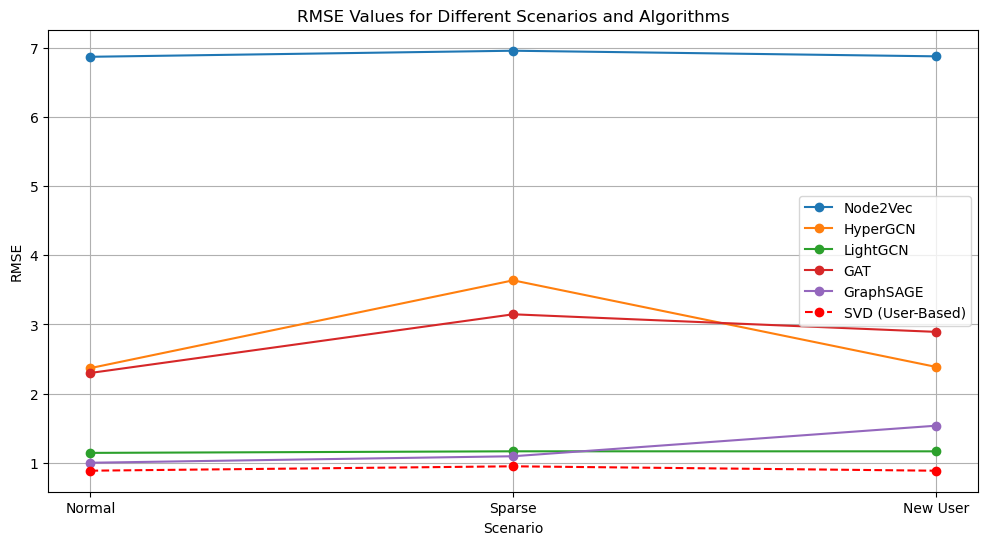

In [69]:
# Plotting the RMSE values for all scenarios and algorithms in the combined DataFrame
plt.figure(figsize=(12, 6))

for algorithm in final_combined_results['Algorithm'].unique():
    subset = final_combined_results[final_combined_results['Algorithm'] == algorithm]
    plt.plot(subset['Scenario'], subset['RMSE'], marker='o', label=algorithm)

# Plot the best algorithm (SVD User-Based)
plt.plot(df_svd['Scenario'], df_svd['RMSE'], marker='o', linestyle='--', color='red', label='SVD (User-Based)')

plt.xlabel('Scenario')
plt.ylabel('RMSE')
plt.title('RMSE Values for Different Scenarios and Algorithms')
plt.legend()
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has

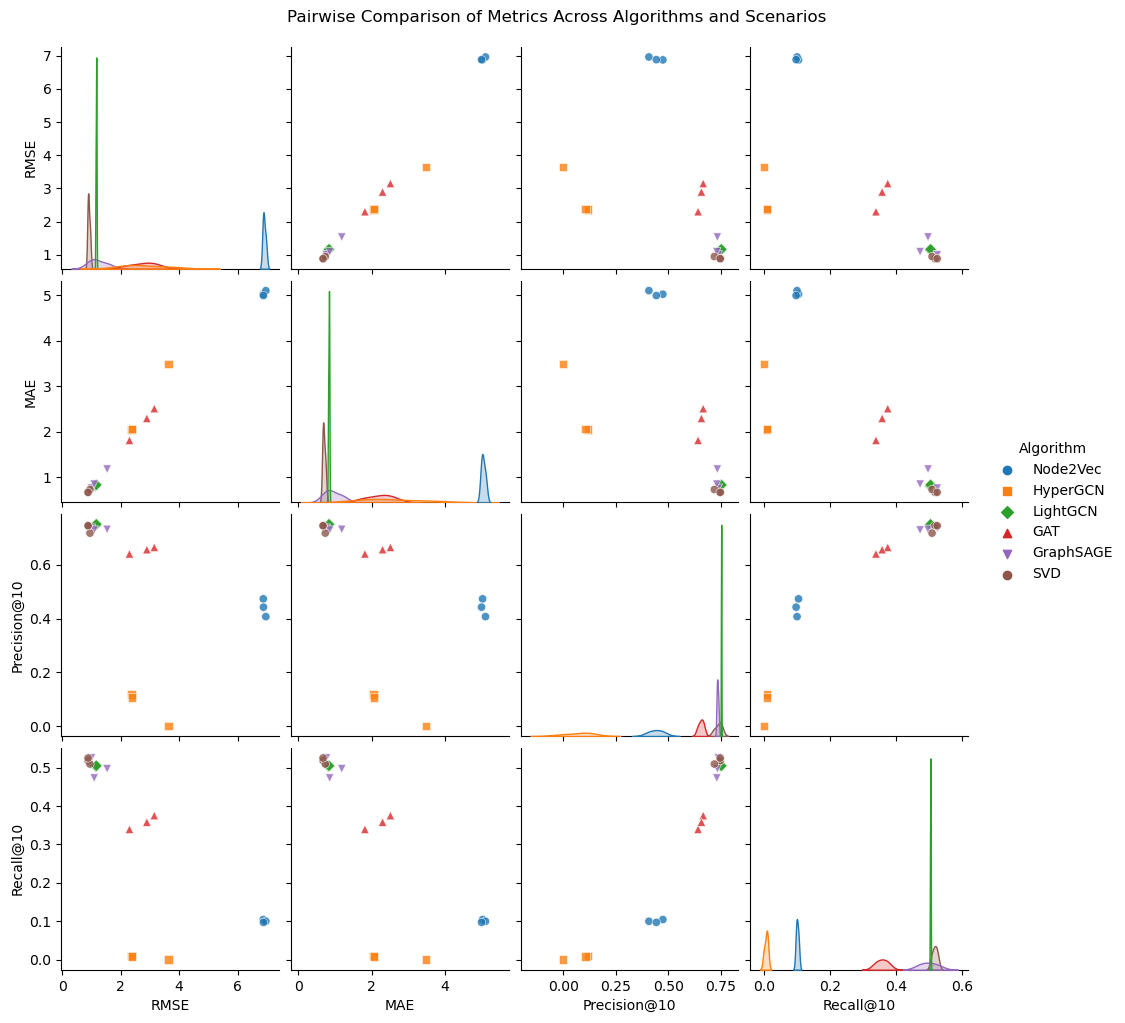

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting relevant columns for the pairplot
pairplot_df = final_combined_results_svd[["Algorithm", "Scenario", "RMSE", "MAE", "Precision@10", "Recall@10"]]

# Generating the pairplot
sns.pairplot(pairplot_df, hue="Algorithm", markers=["o", "s", "D", "^", "v"], plot_kws={'alpha':0.8})

plt.suptitle('Pairwise Comparison of Metrics Across Algorithms and Scenarios', y=1.02)
plt.show()